In [18]:
import numpy as np
from matplotlib.transforms import Affine2D
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import astropy.io.fits as fits
from scipy.ndimage import median_filter

#### $\color{magenta}{\text{We import the necessary datasets and calculate $B_x,\,B_y,\,B_z$.}} $

In [2]:
atmos = fits.open('qs_ph_disk_center.fits')[0].data[:,15,:128,:128] # logtau = 0
B, inc, az = atmos[4], np.radians(atmos[6]), np.radians(atmos[7]) # [-90,90] degrees

Bx = B * np.sin(inc) * np.cos(az) # always > 0
By = B * np.sin(inc) * np.sin(az)
Bz = B * np.cos(inc) # same as Blos since we work with disk center data
Btr = np.sqrt(Bx**2 + By**2)

#### $\color{magenta}{\text{We make data ambiguous by randomly flipping $50\%$ of pixels.}} $

In [3]:
Bx_ambig, By_ambig, az_ambig = Bx.copy(), By.copy(), az.copy()

flip_prob = 0.5
flip_mask = (np.random.rand(*Bx_ambig.shape) < flip_prob)

Bx_ambig[flip_mask] *= -1
By_ambig[flip_mask] *= -1
az_ambig[flip_mask] *= -1
Btr_ambig = np.sqrt(Bx_ambig**2 + By_ambig**2)

#### $\color{magenta}{\text{We compare original to ambiguous version.}} $

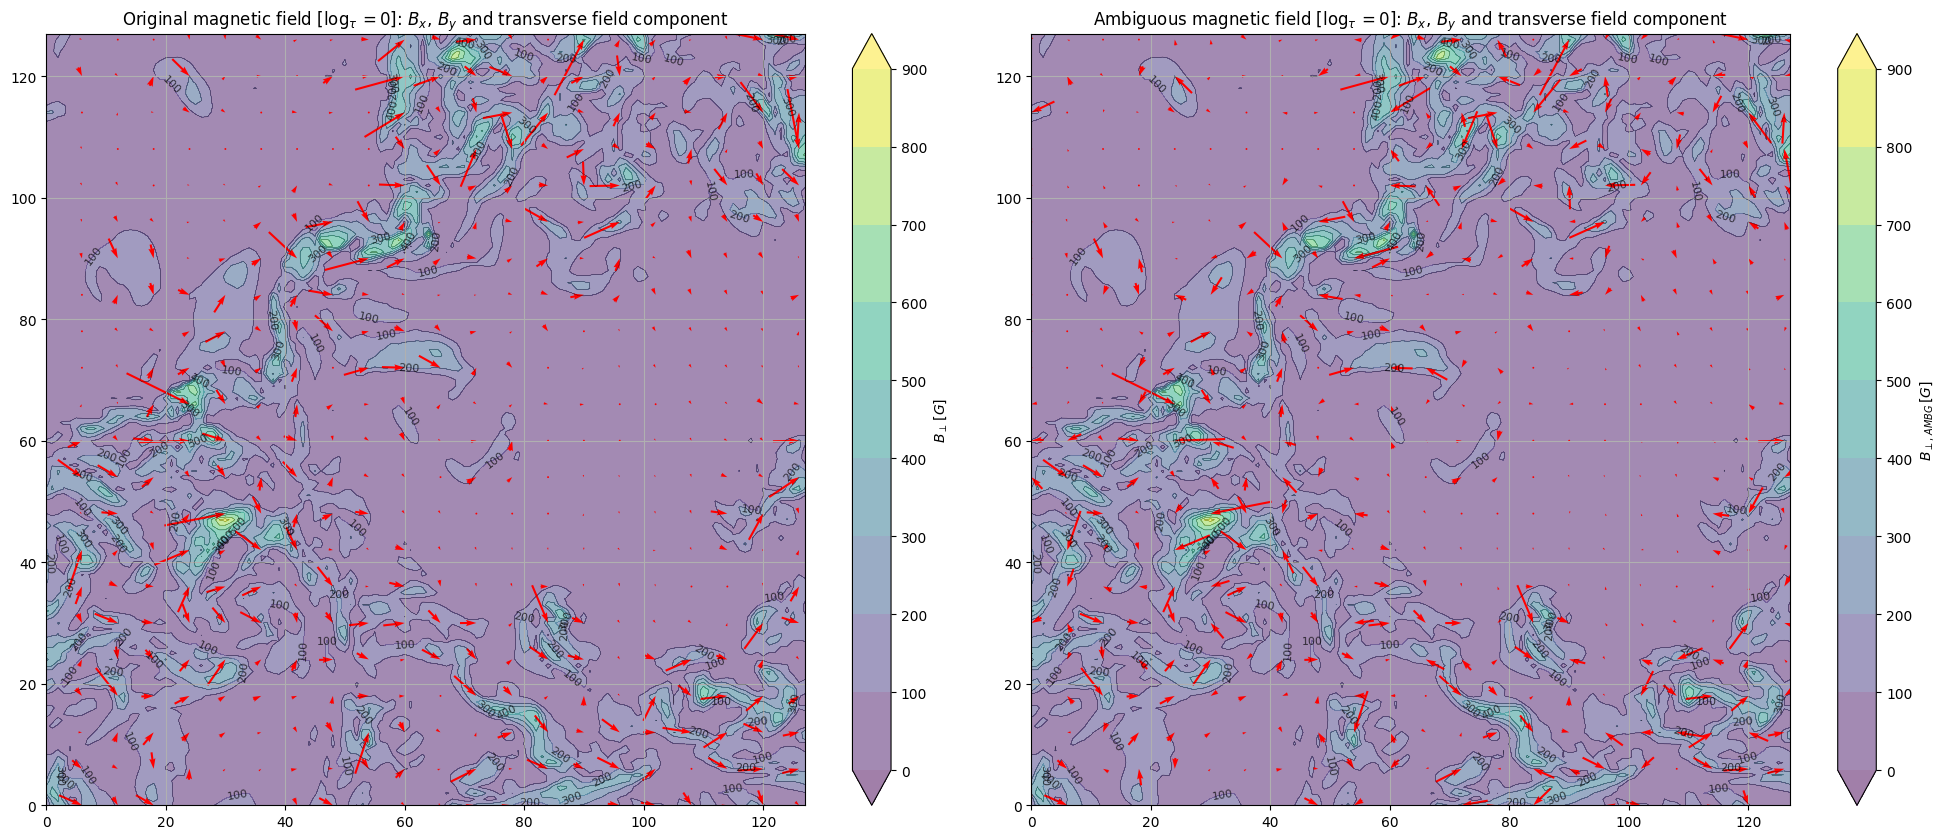

In [4]:
plt.figure(figsize=(20, 8.5))

skip = 6
levels = np.linspace(0, 900, 10)

x, y = np.arange(0, B.shape[1], skip), np.arange(0, B.shape[0], skip)
X, Y = np.meshgrid(x, y)

Bx_s0, By_s0 = Bx[::skip, ::skip], By[::skip, ::skip]
Bx_s1, By_s1 = Bx_ambig[::skip, ::skip], By_ambig[::skip, ::skip]

plt.subplot(121)
contour = plt.contourf(Btr, levels=levels, extend='both', alpha=0.5)
plt.colorbar(contour, label=r'$B_{\perp}\,[G]$')
contour_lines = plt.contour(Btr, levels=levels, colors='black', linewidths=0.25, alpha=0.7)
plt.clabel(contour_lines, inline=True, fontsize=8)
plt.quiver(X, Y, Bx_s0, By_s0, color='red', angles='xy', scale_units='xy', scale=50, pivot='tip')
plt.grid()
plt.title(r'Original magnetic field [$\log_{\tau}=0$]: $B_x,\,B_y$ and transverse field component')

plt.subplot(122)
contour = plt.contourf(Btr_ambig, levels=levels, extend='both', alpha=0.5)
plt.colorbar(contour, label=r'$B_{\perp,\,AMBG}\,[G]$')
contour_lines = plt.contour(Btr_ambig, levels=levels, colors='black', linewidths=0.25, alpha=0.7)
plt.clabel(contour_lines, inline=True, fontsize=8)
plt.quiver(X, Y, Bx_s1, By_s1, color='red', angles='xy', scale_units='xy', scale=50, pivot='tip')
plt.grid()
plt.title(r'Ambiguous magnetic field [$\log_{\tau}=0$]: $B_x,\,B_y$ and transverse field component')

plt.tight_layout()
plt.show()

#### $\color{magenta}{\text{We proceed to MINIMUM ENERGY disambiguation.}} $

In [5]:
from minimum_energy_method import MinimumEnergyDisambiguator

disambig = MinimumEnergyDisambiguator(Bx_ambig, By_ambig, Bz, az=az_ambig, dx=1, dy=1, lambda_factor=3)

disambig.simulated_annealing(
    neq=300, # number of reconfiguration attempts per temperature step (100-500)
    tfac0=0.1, # initial temperature scaling factor (0.05-0.2)
    tfactr=0.96, # cooling rate (0.85-0.98)
    tol_conv=1e-4, # convergence tolerance for relative energy change (1e-5-1e-4)
    nconv_min=50, # number of consecutive iterations with negligible change required for convergence (10-100)
    tstop_par=1e-4, # stopping temperature as a fraction of the initial temperature (1e-3-1e-5)
    max_iter=200, # maximum number of iterations (100-1000)
    Btr_threshold=200 # transverse magnetic field component threshold (100-200: strong)
)
disambig.acute_angle_weak(Btr_threshold=200, # transverse magnetic field component threshold (weak)
                          max_iterations=10, # number of iterations (5-20)
                          conv_threshold=1e-3) # convergence threshold 
disambig.save_disambiguation_results()

Disambiguation [strong-masked fields] - simulated_annealing procedure:  45%|████████████████████████████████████▍                                            | 90/200 [00:28<00:34,  3.15it/s]


Minimum energy disambiguation is done and results are saved!


#### $\color{magenta}{\text{We import and analyze minimum energy disambiguated data.}} $

In [6]:
Bx_mem, By_mem = fits.open('MEM_disambiguation_results.fits')[0].data, fits.open('MEM_disambiguation_results.fits')[1].data
az_mem, Jz_mem = fits.open('MEM_disambiguation_results.fits')[2].data, fits.open('MEM_disambiguation_results.fits')[3].data
Btr_mem = np.sqrt(Bx_mem**2 + By_mem**2)

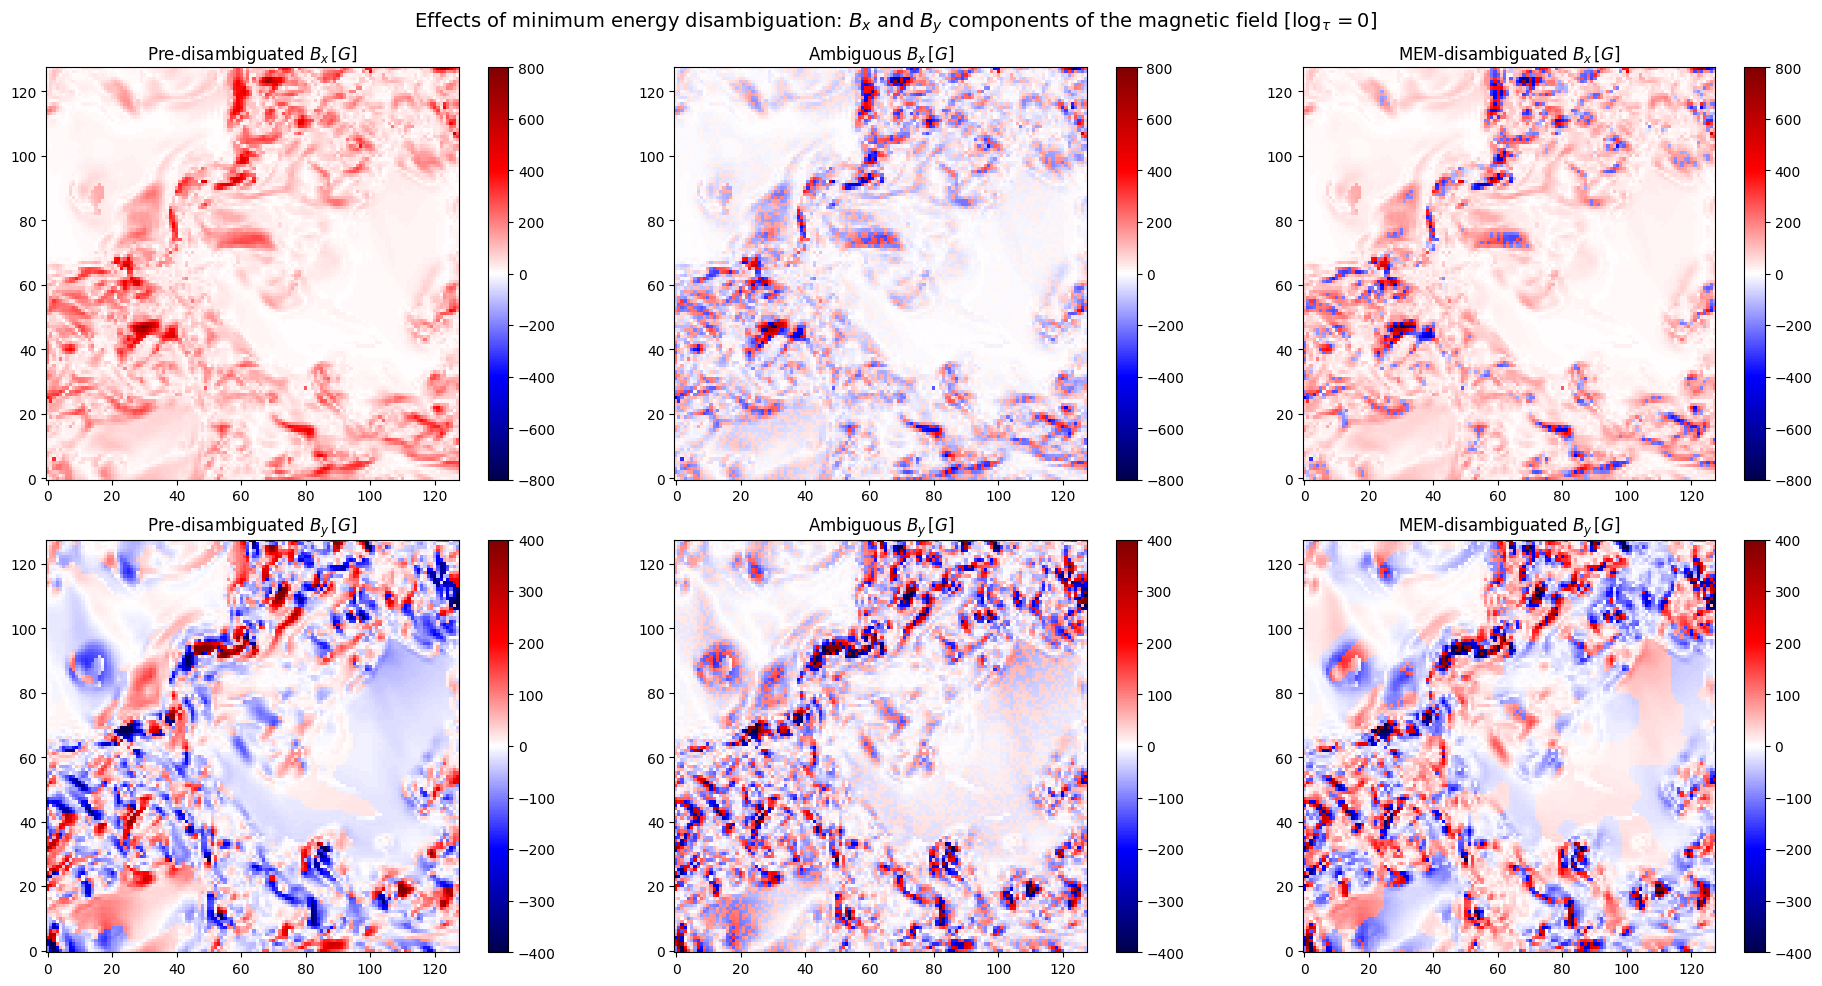

In [7]:
plots = [Bx, Bx_ambig, Bx_mem, By, By_ambig, By_mem]
titles = [r'Pre-disambiguated $B_x\,[G]$', 
          r'Ambiguous $B_x\,[G]$', 
          r'MEM-disambiguated $B_x\,[G]$', 
          r'Pre-disambiguated $B_y\,[G]$', 
          r'Ambiguous $B_y\,[G]$', 
          r'MEM-disambiguated $B_y\,[G]$']

fig, axes = plt.subplots(2, 3, figsize=(19, 10))

for i in range(2):
    for j in range(3):
        idx = i * 3 + j
        ax = axes[i, j]
        if i == 0: 
            vmin, vmax = -800, 800
        else:
            vmin, vmax = -400, 400
        im = ax.imshow(plots[idx], origin='lower', cmap='seismic', vmin=vmin, vmax=vmax)
        ax.set_title(titles[idx])
        fig.colorbar(im, ax=ax)

plt.suptitle(r'Effects of minimum energy disambiguation: $B_x$ and $B_y$ components of the magnetic field [$\log_{\tau}=0$]',
            fontsize=14)
plt.tight_layout()
plt.show()

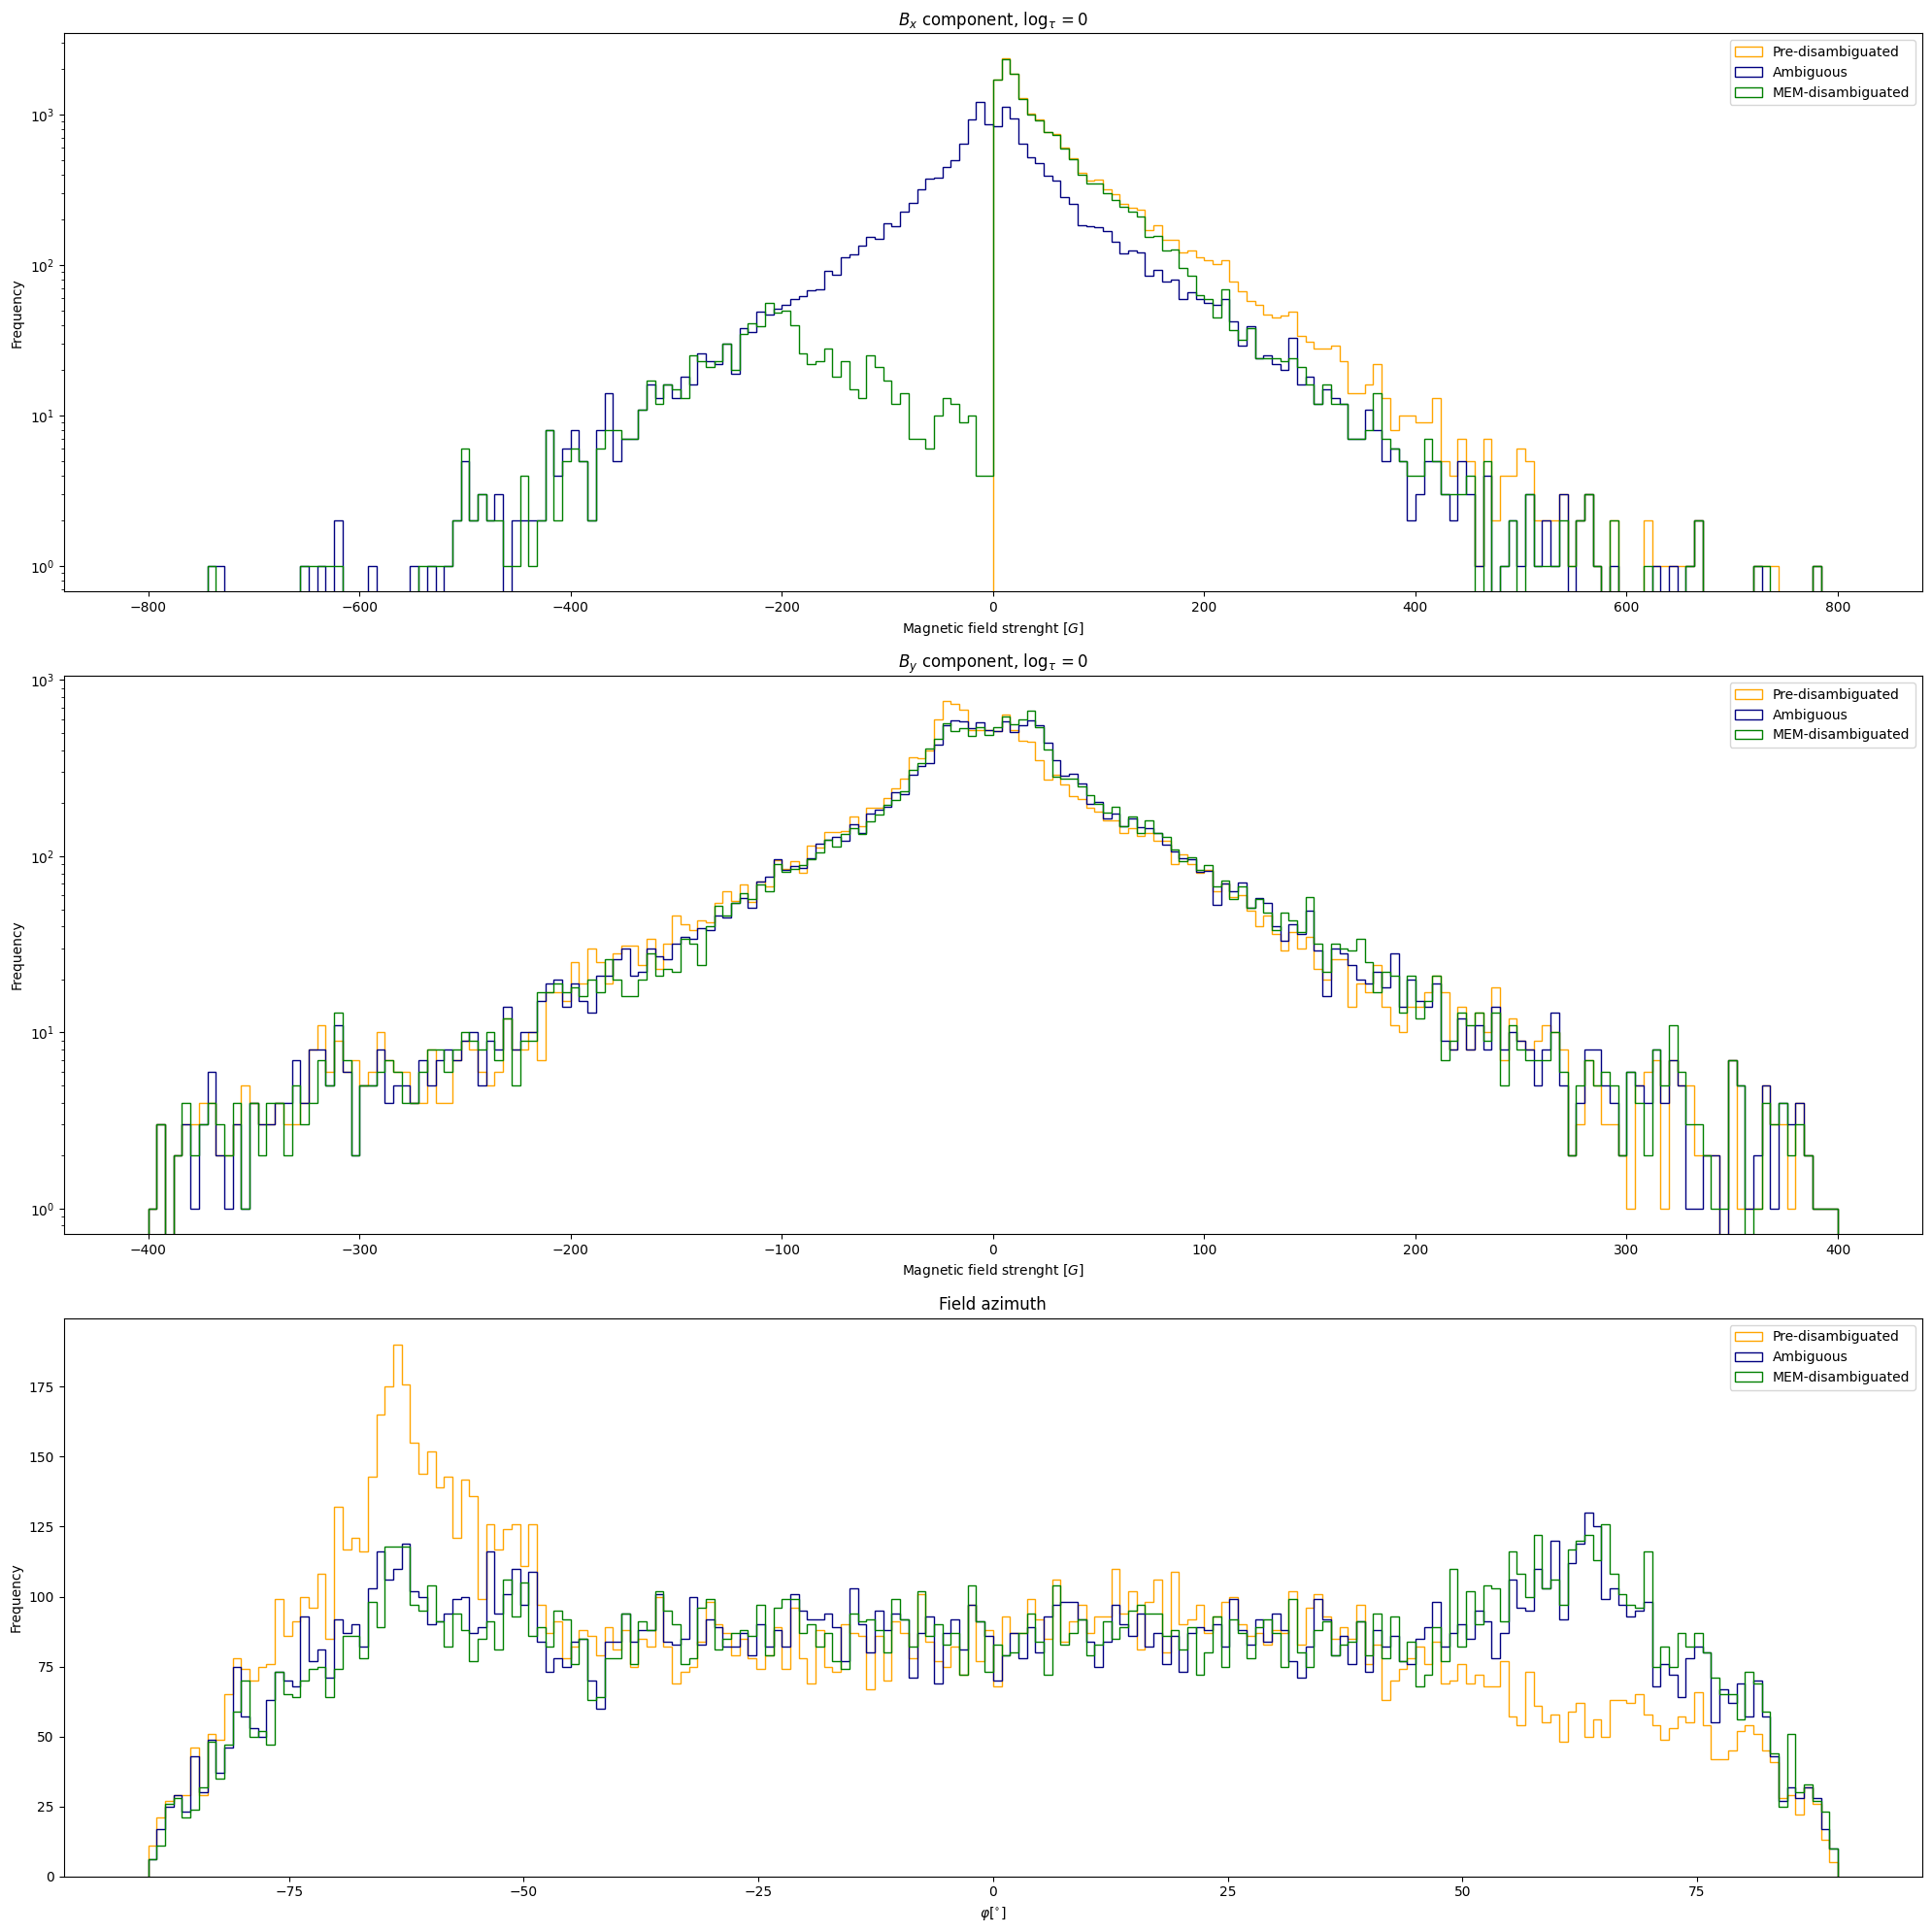

In [8]:
plt.figure(figsize=(20,20))

plt.subplot(311)
plt.hist(Bx.ravel(), bins=200, color='orange', label=r'Pre-disambiguated', histtype='step', range=(-800,800))
plt.hist(Bx_ambig.ravel(), bins=200, color='navy', label=r'Ambiguous', histtype='step', range=(-800,800))
plt.hist(Bx_mem.ravel(), bins=200, color='green', label=r'MEM-disambiguated', histtype='step', range=(-800,800))
plt.title(r'$B_x$ component, $\log_{\tau}=0$')
plt.xlabel(r'Magnetic field strenght $[G]$')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend()

plt.subplot(312)
plt.hist(By.ravel(), bins=200, color='orange', label=r'Pre-disambiguated', histtype='step', range=(-400,400))
plt.hist(By_ambig.ravel(), bins=200, color='navy', label=r'Ambiguous', histtype='step', range=(-400,400))
plt.hist(By_mem.ravel(), bins=200, color='green', label=r'MEM-disambiguated', histtype='step', range=(-400,400))
plt.title(r'$B_y$ component, $\log_{\tau}=0$')
plt.xlabel(r'Magnetic field strenght $[G]$')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend()

plt.subplot(313)
plt.hist(np.degrees(az).ravel(), bins=200, histtype='step', color='orange', label=r'Pre-disambiguated', range=(-90,90))
plt.hist(np.degrees(az_ambig).ravel(), bins=200, histtype='step', color='navy', label=r'Ambiguous',  range=(-90,90))
plt.hist(az_mem.ravel(), bins=200, histtype='step', color='green', label=r'MEM-disambiguated',  range=(-90,90))
plt.title(r'Field azimuth')
plt.xlabel(r'$\varphi[^{\circ}]$')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

#### $\color{magenta}{\text{With the standard procedures of analysis, we have limited insight. So, we use}}$
#### $\color{magenta}{\text{additional metric developed in paper: Leka, K. D. et al. 2009, Solar Phys., 260, 83–108 
}}$

1. **Fraction correct (area metric):**

$$
M_{\text{area}} = \frac{\#\{\,|\Delta\theta| < \text{tol}\,\}}{N_{\text{pixels}}}
$$

Here, $\Delta\theta = \min\bigl(|\theta_{\text{true}} - \theta_{\text{sol}}|,\,180^\circ - |\theta_{\text{true}} - \theta_{\text{sol}}|\bigr)$ is the smallest angular difference, and tol is 

the tolerance (in degrees). True goes for
pre-disambiguated data, and sol is for disambiguated case.

---

2. **Normalized vertical current metric:**

$$
M_{J_z} = 1 - \frac{\sum_{i} \left| J_{z,\text{true}}(i) - J_{z,\text{sol}}(i) \right|}{2\,\sum_{i} \left| J_{z,\text{true}}(i) \right|}
$$

This metric compares the vertical current density of the solution with the reference, with a 

perfect match yielding $M_{J_z}=1$.

---

3. **Total unsigned vertical current:**

$$
I = \sum_{i} \left| J_{z,\text{sol}}(i) \right|
$$

This sums the absolute vertical current over all pixels, quantifying the overall current.

---

4. **Fraction correct in strong transverse field regions:**

$$
M_{B_\perp>T} = \frac{\sum_{i \in \{B_{\perp,\text{true}} \ge T\}} \mathbf{1}\bigl\{|\Delta\theta(i)| < \text{tol}\bigr\}}{\sum_{i \in \{B_{\perp,\text{true}} \ge T\}} 1}
$$

Only pixels with $B_{\perp,\text{true}}$ above a threshold $T$ are considered; $\mathbf{1}\{\cdot\}$ is 1 

if the angular difference is within tol, and 0 otherwise.*

---

5. **Mean horizontal vector difference:**

$$
M_{\Delta B} = \frac{1}{N}\sum_{i} \sqrt{\bigl(B_{x,\text{sol}}(i) - B_{x,\text{true}}(i)\bigr)^2 + \bigl(B_{y,\text{sol}}(i) - B_{y,\text{true}}(i)\bigr)^2}
$$

This is the average magnitude of the difference between the disambiguated and pre-disambiguated

horizontal  field components.

In [9]:
dBy_dx = np.gradient(By, axis=0)
dBx_dy = np.gradient(Bx, axis=1) 
Jz = dBy_dx - dBx_dy

dBy_dx = np.gradient(By_ambig, axis=0)
dBx_dy = np.gradient(Bx_ambig, axis=1) 
Jz_ambig = dBy_dx - dBx_dy

az = np.degrees(az)
az_ambig = np.degrees(az_ambig)

In [31]:
import pandas as pd
import MEM_disambiguation_metrics as metrics

# Optionally, set a threshold value that will appear in the metric name.
B_threshold = 100.0

def compute_metrics(az_true, Jz_true, Bx_true, By_true, az_sol, Jz_sol, Bx_sol, By_sol):
    return {
        "Fraction correct (area)": metrics.fraction_correct(az_true, az_sol),
        "Normalized current metric": metrics.normalized_current_metric(Jz_true, Jz_sol),
        "Total unsigned current": metrics.total_unsigned_current(Jz_sol),
        "Fraction correct (B⊥ > {threshold} G)": 
            metrics.fraction_correct_strong_field(Bx_true, By_true, az_true, Bx_sol, By_sol, az_sol),
        "Mean horizontal vector diff": metrics.mean_vector_difference(Bx_true, By_true, Bx_sol, By_sol)
    }

# Compute metrics for each method
results = {
    "Ambiguous": compute_metrics(az, Jz, Bx, By, az_ambig, Jz_ambig, Bx_ambig, By_ambig),
    "MEM-disambiguated": compute_metrics(az, Jz, Bx, By, az_mem, Jz_mem, Bx_mem, By_mem)
}

# Convert the dictionary to a DataFrame with metrics as rows and methods as columns.
df = pd.DataFrame(results)
df.index.name = "Metric"

df_styled = df.style.format({
    "Fraction correct (area)": "{:.3f}",
    "Normalized current metric": "{:.3f}",
    "Total unsigned current": "{:.3e}",
    "Fraction correct (B⊥ > ": "{:.3f}",
    "Mean horizontal vector diff": "{:.3f}"
})
display(df_styled)

,Ambiguous,MEM-disambiguated
Metric,,
Fraction correct (area),0.511353,0.500000
Normalized current metric,0.118222,0.406659
Total unsigned current,983743.312500,597889.426581
Fraction correct (B⊥ > {threshold} G),0.529982,0.505148
Mean horizontal vector diff,94.991196,72.680550


In [9]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Flatten the arrays to 1D for metric calculation
Bx_flat = Bx.flatten()
Bx_ambig_flat = Bx_ambig.flatten()
Bx_mem_flat = Bx_mem.flatten()

By_flat = By.flatten()
By_ambig_flat = By_ambig.flatten()
By_mem_flat = By_mem.flatten()

# --- Analysis for Bx Components ---
print("Bx Analysis:")
# Comparison between Pre-disambiguated (Bx) and Ambiguous (Bx_ambig)
mae_Bx_ambig = mean_absolute_error(Bx_flat, Bx_ambig_flat)
rmse_Bx_ambig = np.sqrt(mean_squared_error(Bx_flat, Bx_ambig_flat))
r2_Bx_ambig = r2_score(Bx_flat, Bx_ambig_flat)

print("Bx vs. Bx_ambig:")
print("  MAE:", mae_Bx_ambig)
print("  RMSE:", rmse_Bx_ambig)
print("  R^2:", r2_Bx_ambig)

# Comparison between Pre-disambiguated (Bx) and MEM-disambiguated (Bx_mem)
mae_Bx_mem = mean_absolute_error(Bx_flat, Bx_mem_flat)
rmse_Bx_mem = np.sqrt(mean_squared_error(Bx_flat, Bx_mem_flat))
r2_Bx_mem = r2_score(Bx_flat, Bx_mem_flat)

print("Bx vs. Bx_mem:")
print("  MAE:", mae_Bx_mem)
print("  RMSE:", rmse_Bx_mem)
print("  R^2:", r2_Bx_mem)


# --- Analysis for By Components ---
print("\nBy Analysis:")
# Comparison between Pre-disambiguated (By) and Ambiguous (By_ambig)
mae_By_ambig = mean_absolute_error(By_flat, By_ambig_flat)
rmse_By_ambig = np.sqrt(mean_squared_error(By_flat, By_ambig_flat))
r2_By_ambig = r2_score(By_flat, By_ambig_flat)

print("By vs. By_ambig:")
print("  MAE:", mae_By_ambig)
print("  RMSE:", rmse_By_ambig)
print("  R^2:", r2_By_ambig)

# Comparison between Pre-disambiguated (By) and MEM-disambiguated (By_mem)
mae_By_mem = mean_absolute_error(By_flat, By_mem_flat)
rmse_By_mem = np.sqrt(mean_squared_error(By_flat, By_mem_flat))
r2_By_mem = r2_score(By_flat, By_mem_flat)

print("By vs. By_mem:")
print("  MAE:", mae_By_mem)
print("  RMSE:", rmse_By_mem)
print("  R^2:", r2_By_mem)


Bx Analysis:
Bx vs. Bx_ambig:
  MAE: 67.82734680175781
  RMSE: 147.34077078112153
  R^2: -2.5258097648620605
Bx vs. Bx_mem:
  MAE: 26.202377319335938
  RMSE: 120.13588497769932
  R^2: -1.3440048694610596

By Analysis:
By vs. By_ambig:
  MAE: 54.91361999511719
  RMSE: 120.80419817570497
  R^2: -0.9906792640686035
By vs. By_mem:
  MAE: 56.06326675415039
  RMSE: 123.38281621010886
  R^2: -1.0765700340270996


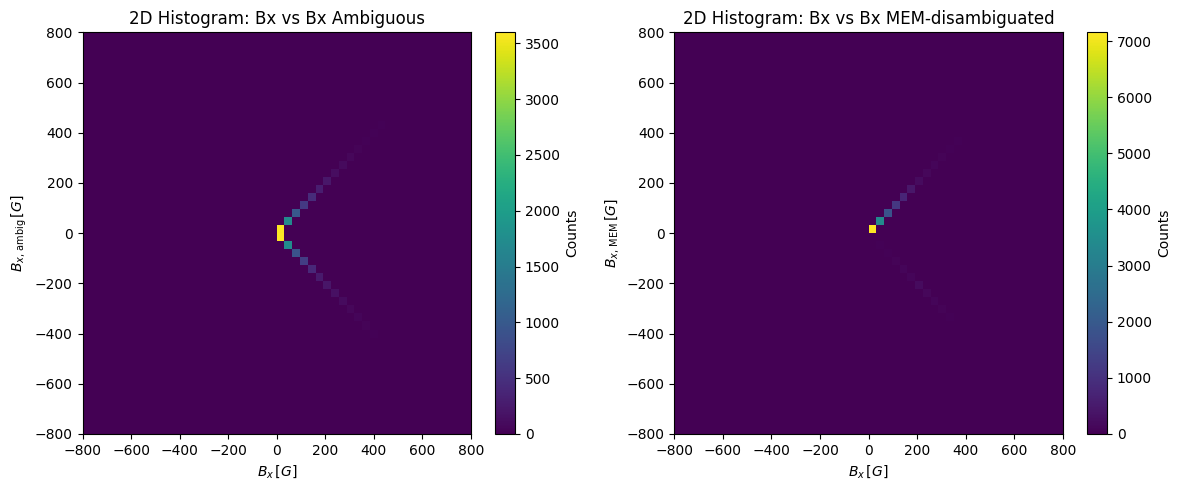

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 2D histogram: Bx vs Bx_ambig
plt.subplot(1, 2, 1)
plt.hist2d(Bx.ravel(), Bx_ambig.ravel(), bins=50, range=[[-800,800], [-800,800]], cmap='viridis')
plt.xlabel(r'$B_x\,[G]$')
plt.ylabel(r'$B_{x,\,\text{ambig}}\,[G]$')
plt.title('2D Histogram: Bx vs Bx Ambiguous')
plt.colorbar(label='Counts')

# 2D histogram: Bx vs Bx_mem
plt.subplot(1, 2, 2)
plt.hist2d(Bx.ravel(), Bx_mem.ravel(), bins=50, range=[[-800,800], [-800,800]], cmap='viridis')
plt.xlabel(r'$B_x\,[G]$')
plt.ylabel(r'$B_{x,\,\text{MEM}}\,[G]$')
plt.title('2D Histogram: Bx vs Bx MEM-disambiguated')
plt.colorbar(label='Counts')

plt.tight_layout()
plt.show()



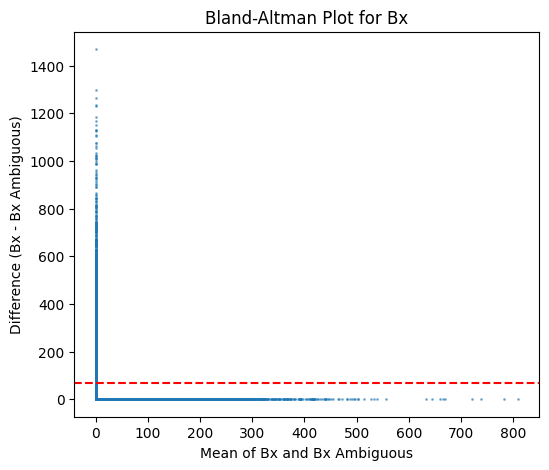

In [90]:
mean_Bx = (Bx + Bx_ambig) / 2
diff_Bx = Bx - Bx_ambig
plt.figure(figsize=(6,5))
plt.scatter(mean_Bx.ravel(), diff_Bx.ravel(), s=1, alpha=0.5)
plt.axhline(np.mean(diff_Bx), color='red', linestyle='--')
plt.xlabel('Mean of Bx and Bx Ambiguous')
plt.ylabel('Difference (Bx - Bx Ambiguous)')
plt.title('Bland-Altman Plot for Bx')
plt.show()


In [ ]:


crl1 = np.corrcoef(Bx.flatten(), Bx_ambig.flatten())[0, 1]
crl2 = np.corrcoef(Bx.flatten(), Bx_mem.flatten())[0, 1] 
crl3 = np.corrcoef(By.flatten(), By_ambig.flatten())[0, 1]
crl4 = np.corrcoef(By.flatten(), By_mem.flatten())[0, 1] 

print(crl1, crl2, crl3, crl4)

plt.figure(figsize=(20,20))

plt.subplot(431)
plt.imshow(Bx, origin='lower', cmap='bwr')
plt.title(r'$B_x\,[G]$, $\log_{\tau}=0$')
plt.colorbar()

plt.subplot(432)
plt.imshow(Bx_ambig, origin='lower', cmap='bwr')
plt.title(r'$B_{x,\,\text{flipped}}\,[G]$, $\log_{\tau}=0$')
plt.colorbar()

plt.subplot(433)
plt.imshow(Bx_mem, origin='lower', cmap='bwr')
plt.title(r'$B_{x,\,\text{MEM}}\,[G]$, $\log_{\tau}=0$')
plt.colorbar()

plt.subplot(434)
plt.imshow(By, origin='lower', cmap='bwr')
plt.title(r'$B_y\,[G]$, $\log_{\tau}=0$')
plt.colorbar()

plt.subplot(435)
plt.imshow(By_ambig, origin='lower', cmap='bwr')
plt.title(r'$B_{y,\,\text{flipped}}\,[G]$, $\log_{\tau}=0$')
plt.colorbar()

plt.subplot(436)
plt.imshow(By_mem, origin='lower', cmap='bwr')
plt.title(r'$B_{y,\,\text{MEM}}\,[G]$, $\log_{\tau}=0$')
plt.colorbar()

plt.subplot(4,3,(7,8))
plt.hist(Bx.ravel(), 200, color='orange', label=r'Pre-disambiguated', histtype='step', range=(-800,800))
plt.hist(Bx_ambig.ravel(), 200, color='navy', label=r'Ambiguous', histtype='step', range=(-800,800))
plt.hist(Bx_mem.ravel(), 200, color='green', label=r'MEM-disambiguated', histtype='step', range=(-800,800))
plt.title(r'$B_x\,[G]$, $\log_{\tau}=0$')
plt.legend()

plt.subplot(4, 3, (9, 12))
plt.hist(np.degrees(az).ravel(), bins=60, orientation='horizontal', histtype='step', color='orange', label=r'Pre-disambiguated')
plt.hist(np.degrees(az_ambig).ravel(), bins=60, orientation='horizontal', histtype='step', color='navy', label=r'Ambiguous')
plt.hist(az_mem.ravel(), bins=60, orientation='horizontal', histtype='step', color='green', label=r'MEM-disambiguated')
plt.title(r'$\varphi[^{\circ}]$')
plt.legend()


plt.subplot(4,3,(10,11))
plt.hist(By.ravel(), 200, color='orange', label=r'Pre-disambiguated', histtype='step', range=(-400,400))
plt.hist(By_ambig.ravel(), 200, color='navy', label=r'Ambiguous', histtype='step', range=(-400,400))
plt.hist(By_mem.ravel(), 200, color='green', label=r'MEM-disambiguated', histtype='step', range=(-400,400))
plt.title(r'$B_y\,[G]$, $\log_{\tau}=0$')
plt.legend()

plt.show()

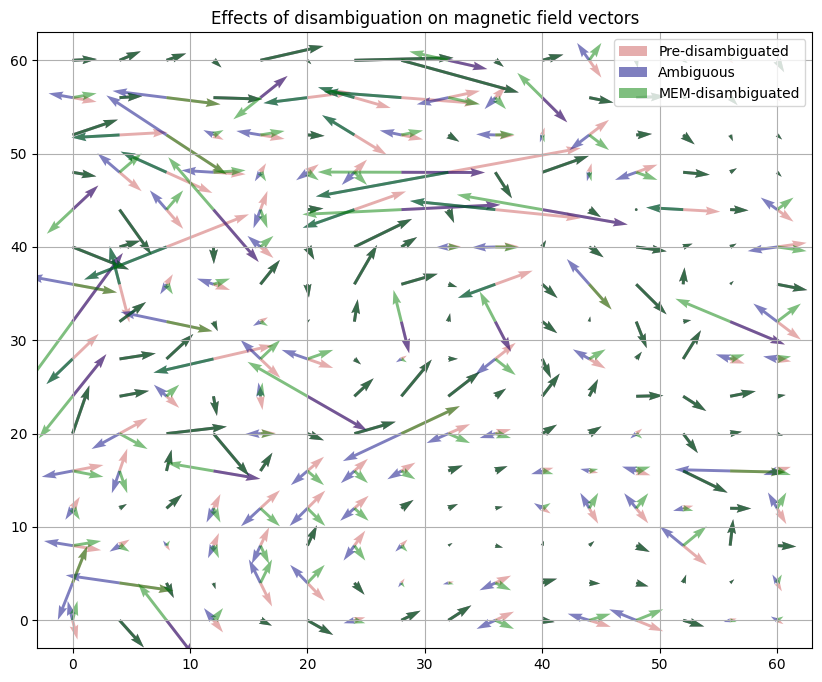

In [17]:
plt.figure(figsize=(10,8))

skip = 4
levels = np.linspace(0, 1400, 10)

x = np.arange(0, B.shape[1], skip)
y = np.arange(0, B.shape[0], skip)
X, Y = np.meshgrid(x, y)

Bx_s0 = Bx[::skip, ::skip]
By_s0 = By[::skip, ::skip]
Bx_s1 = Bx_ambig[::skip, ::skip]
By_s1 = By_ambig[::skip, ::skip]
Bx_s2 = Bx_mem[::skip, ::skip]
By_s2 = By_mem[::skip, ::skip]

# contour = plt.contour(Btr, levels=levels, extend='both')
#plt.colorbar(contour, label=r'$B_{\perp}\,[G]$, $\log_{\tau}=0$')
plt.quiver(X, Y, Bx_s0, By_s0, color='indianred', angles='xy', scale_units='xy', alpha=0.5, scale=50, label='Pre-disambiguated')
plt.quiver(X, Y, Bx_s1, By_s1, color='navy', angles='xy', scale_units='xy', alpha=0.5, scale=50, label='Ambiguous')
plt.quiver(X, Y, Bx_s2, By_s2, color='green', angles='xy', scale_units='xy',  alpha=0.5, scale=50, label='MEM-disambiguated')
plt.legend()
plt.grid()
plt.title('Effects of disambiguation on magnetic field vectors')
plt.show()